In [20]:
#Import Statements

import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split

% pylab inline

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['figure', 'show', 'save', 'subtract']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def preprocess(df):
    
    # Feature engineering for categorical variables captured as numbers
    # Turn MSSubClass into factors
    code = ['20', '30', '40', '45', '50', '60', '70', '75', '80', '85', '90', '120', '150', '160', '180', '190']
    strings = ['1-STORY 1946 & NEWER ALL STYLES', '1-STORY 1945 & OLDER', '1-STORY W/FINISHED ATTIC ALL AGES', '1-1/2 STORY - UNFINISHED ALL AGES',\
     '1-1/2 STORY FINISHED ALL AGES', '2-STORY 1946 & NEWER', '2-STORY 1945 & OLDER', '2-1/2 STORY ALL AGES', \
     'SPLIT OR MULTI-LEVEL', 'SPLIT FOYER', 'DUPLEX - ALL STYLES AND AGES', '1-STORY PUD (Planned Unit Development) - 1946 & NEWER',\
     '1-1/2 STORY PUD - ALL AGES', '2-STORY PUD - 1946 & NEWER', 'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER', \
     '2 FAMILY CONVERSION - ALL STYLES AND AGES']

    MSSubClass=dict(zip(code,strings))
    df['MSSubClass']=[MSSubClass[str(val)] for val in df['MSSubClass']]

    # Turn month sold into factors
    months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']
    df['MoSold'] = df['MoSold'].replace(to_replace = df['MoSold'].value_counts().index.sort_values(),value=months)
    
    # Feature engineering for age-related variables
    # Convert yearsold vs yearbuilt into age of house
    df['Age'] =  df['YrSold'] - df['YearBuilt']
    df = df.drop('YearBuilt', 1)
    # Convert yearsold vs. yearremodadd into age of remodel. Adding 2 to eliminate any negative or 0 values
    df['AgeRem'] = (df['YrSold'] - df['YearRemodAdd'])+2
    df = df.drop('YearRemodAdd', 1)
    # Remove age of garage - many missing values (if no garage)
    #  no additional valuable information (garage captured in other variables); age of house more important for age
    df = df.drop('GarageYrBlt', 1)
   
    # Fill select variables with most common / mode where logical
    # Most masonry veneer type is None and area is 0
    df['MasVnrType'] = df['MasVnrType'].fillna('None')
    df['MasVnrArea'] = df['MasVnrArea'].fillna(0.0)
    # Most electrical is 'SBrkr'
    df['Electrical'] = df['Electrical'].fillna('SBrkr')
    df['LotFrontage'] = df['LotFrontage'].fillna(np.mean(df['LotFrontage']))
    df=df.drop('Id',1)
    
    return df

In [3]:
def get_dummies(X_df):
    # Dummify X data
    X_dummy = pd.get_dummies(X_df,dummy_na=True)
    return X_dummy

In [4]:
def level_cat(df_train,df_comp):
    traincols = list(df_train.columns.values)
    testcols = list(df_comp.columns.values)
    
    # Align train data columns to competition data columns
    missingcols1 = list(set(testcols)-set(traincols))
    for col in missingcols1:
        df_train[col] = 0.0

    # Align test data columns to competition data columns
    missingcols = list(set(traincols)-set(testcols))
    print len(missingcols)
    for col in missingcols:
        df_comp[col] = 0.0
    df_comp = df_comp[traincols+missingcols1]
    
    return df_train,df_comp

In [5]:
housedata = preprocess(pd.read_csv('train.csv'))

# Split into X and y
y = (housedata['SalePrice'])

X = housedata.drop('SalePrice', 1)


X = get_dummies(X)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33, random_state=1)

In [12]:
from bokeh.charts import Bar, BoxPlot, Histogram
from bokeh.io import output_notebook, show
output_notebook()

p = BoxPlot(housedata, values='SalePrice', label='Neighborhood', color='Neighborhood',
            title="Price Summary (grouped by Neighborhood)", legend=None, plot_height=500)


show(p)

Loading BokehJS ...

In [24]:
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.models.widgets import Panel, Tabs
from bokeh.io import output_notebook, show, output_file, save

output_notebook()

source1 = ColumnDataSource(
        data=dict(
            x1=housedata['LotArea'],
            y=housedata['SalePrice'],
            desc=housedata['Neighborhood']
        )
    )

hover1 = HoverTool(
        tooltips=[
            ("desc", "@desc"),
        ]
    )

source2 = ColumnDataSource(
        data=dict(
            y=housedata['SalePrice'],
            x2=housedata['GrLivArea'],
            desc=housedata['Neighborhood']
        )
    )

hover2 = HoverTool(
        tooltips=[
            ("desc", "@desc"),
        ]
    )
source3 = ColumnDataSource(
        data=dict(
            y=housedata['SalePrice'],
            x3=housedata['Age'],
            desc=housedata['LotArea'],
            Neighborhood=housedata['Neighborhood']
        )
    )

hover3 = HoverTool(
        tooltips=[
            ("desc", "@desc"),
            ("Neighborhood", "@Neighborhood")
        ]
    )
p1 = figure(plot_width=400, plot_height=400, tools=[hover1],
           title="Mouse over the dots")
p1.circle('x1', 'y', size=20, source=source1, color='green',alpha=0.5)
tab1 = Panel(child=p1, title="LotArea")

p2 = figure(plot_width=400, plot_height=400, tools=[hover2])
p2.circle('x2', 'y', size=20, source=source2, color='navy',alpha=0.5)
tab2 = Panel(child=p2, title="GroundFloorLivingArea")

p3 = figure(plot_width=400, plot_height=400, tools=[hover3])
p3.circle('x3', 'y', size=20, source=source3, color='red',alpha=0.5)
tab3 = Panel(child=p3, title="Age")

tabs = Tabs(tabs=[ tab1, tab2, tab3 ])


show(tabs)

Loading BokehJS ...

In [29]:
from bokeh.charts import Scatter
source1 = ColumnDataSource(
        data=dict(
            x1=housedata['GrLivArea'],
            y=housedata['SalePrice'],
            desc=housedata['Neighborhood']
        )
    )

p = Scatter(housedata, x='GrLivArea', y='SalePrice', color='Neighborhood', title="GrLivArea vs SalePrice (shaded by Neighborhood)",
            xlabel='GrLivArea', ylabel='SalePrice', legend=None, source=source1, plot_width=500, plot_height=500)
show(p)

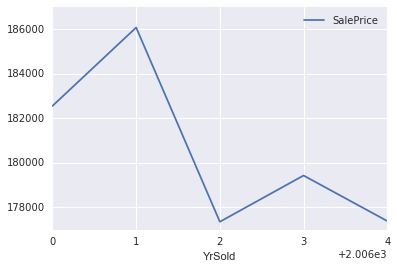

In [297]:
#more graph ideas
#price average changing over time
housedata[['SalePrice', 'YrSold']].groupby(['YrSold']).mean().plot(xticks=(2006,2007,2008,2009,2010))
# fig = plt.figure()
# ax = DF['A','B'].plot(kind="bar");plt.xticks(rotation=0)
# ax2 = ax.twinx()
# ax2.plot(ax.get_xticks(),DF['C','D'],marker='o')

In [19]:
new_df = housedata[['SalePrice','YrSold','Neighborhood']]
new_df2 = new_df.groupby(['Neighborhood','YrSold']).mean()
new_df2 = new_df2.reset_index()

mask1 = new_df2['YrSold'] <= 2008 
mask2 = new_df2['YrSold'] >=2007


new_df3 = new_df2[mask1][mask2]
new_df3[:10]
def subtract(a, b):
    return a-b

pivot = pd.pivot_table(new_df3, index='Neighborhood', values = 'SalePrice', columns='YrSold', fill_value=0)
pivot2 = pivot.reset_index()
pivot2['Avg_diff'] = pivot2[2008] - pivot2[2007]

final = pivot2[['Neighborhood', 'Avg_diff']]
final.set_index('Neighborhood')


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


YrSold,Avg_diff
Neighborhood,
Blmngtn,-7903
Blueste,151000
BrDale,-18608
BrkSide,-14030
ClearCr,-27342
CollgCr,-26281
Crawfor,55634
Edwards,-115
Gilbert,4033


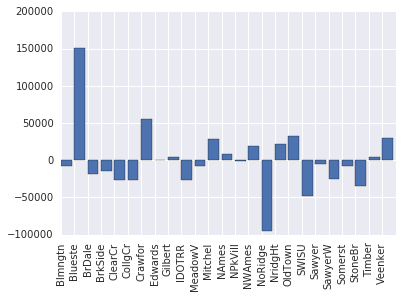

In [422]:
import pylab as plt 
plt.bar(final.index,final['Avg_diff'])
plt.xticks(final.index,final['Neighborhood'], rotation='vertical')
plt.show()

In [433]:
#Bluestem near Iowa State campus
def location(s):
    if s=='Crawfor' or s=='BrkSide' or s== 'ClearCr' or s=='SWISU' or s== 'Edwards' or s=='NWAmes':
        l=1.0
    else:
        l=0.0
    return l

final['BorderingISU'] = final['Neighborhood'].map(location)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [434]:
final

YrSold,Neighborhood,Avg_diff,BorderingISU
0,Blmngtn,-7903,0.0
1,Blueste,151000,0.0
2,BrDale,-18608,0.0
3,BrkSide,-14030,1.0
4,ClearCr,-27342,1.0
5,CollgCr,-26281,0.0
6,Crawfor,55634,1.0
7,Edwards,-115,1.0
8,Gilbert,4033,0.0
9,IDOTRR,-27291,0.0


In [474]:
from sklearn.linear_model import LogisticRegression
from patsy import dmatrices
from sklearn.metrics import confusion_matrix

final.iloc[1:25, [1]].values
regr = LogisticRegression()
regr.fit(final.iloc[1:15, [1]].values, final.iloc[1:15, 2].values)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [476]:
pred = regr.predict(final.iloc[16:25, [1]].values)
ytrue = final.iloc[16:25, 2]
confusion_matrix(ytrue, pred)

array([[6, 2],
       [0, 1]])

In [477]:
print regr.coef_
print regr.intercept_

[[ -4.90963045e-06]]
[-0.11599473]


In [549]:
from statsmodels.formula.api import logit
model = logit('BorderingISU~Avg_diff', final).fit()
print model.summary()

Optimization terminated successfully.
         Current function value: 0.550350
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:           BorderingISU   No. Observations:                   25
Model:                          Logit   Df Residuals:                       23
Method:                           MLE   Df Model:                            1
Date:                Sun, 04 Dec 2016   Pseudo R-squ.:                0.001325
Time:                        16:46:52   Log-Likelihood:                -13.759
converged:                       True   LL-Null:                       -13.777
                                        LLR p-value:                    0.8485
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -1.1541      0.469     -2.461      0.014        -2.073    -0.235
Avg_diff   -2.143e-06   1.14e

In [478]:
final['Probability'] = np.exp(-0.116-0.0000049*final['Avg_diff'])/(1+np.exp(-0.116-0.0000049*final['Avg_diff']))

In [479]:
final

,Neighborhood,Avg_diff,BorderingISU,log_diff,Probability
0,Blmngtn,-7903,0.0,NaN,0.480691
1,Blueste,151000,0.0,11.925035,0.298197
2,BrDale,-18608,0.0,NaN,0.493795
3,BrkSide,-14030,1.0,NaN,0.488189
4,ClearCr,-27342,1.0,NaN,0.504494
5,CollgCr,-26281,0.0,NaN,0.503194
6,Crawfor,55634,1.0,10.926550,0.404053
7,Edwards,-115,1.0,NaN,0.471173
8,Gilbert,4033,0.0,8.302266,0.466112
9,IDOTRR,-27291,0.0,NaN,0.504431


### Outside Data

In [497]:
def owner_rent(s):
    #owner rate
    if s=='ClearCr':
        o=0.962
    elif s== 'BlueSte':
        o=0.333
#     if s=='SWISU':
#         o=
    elif s=='Veenker':
        o=None
    elif s== 'Timber':
        o=0.333
    elif s=='StoneBr':
        o=0.972
#     elif s=='Somerst':
#         o=0.
    elif s== 'SawyerW':
        o=0.49
    elif s=='Sawyer':
        o=0.556
    elif s=='OldTown':
        o=0.524
    elif s== 'NridgHt':
        o=0.97
    elif s=='NoRidge':
        o=0.604
    elif s=='NWAmes':
        o=0.782
    elif s== 'NPkVill':
        o=0.478
    elif s=='NAmes':
        o=0.59
    elif s=='Mitchel':
        o=0.529
    elif s== 'MeadowV':
        o=0.529
#     if s=='IDOTRR':
#         o=
    elif s=='Gilbert':
        o=0.97
    elif s=='Edwards':
        o=0.285
#     if s== 'BrDale':
#         o=0.
    elif s=='CollgCr':
        o=0.374
#     if s=='BrkSide':
#         o=0.
    elif s== 'Blmngtn':
        o=0.974
    elif s=='Crawfor':
        o=0.569
    else:
        o=None
    return o
        
    
def fam_size(s):
    #percent of small family
    if s=='ClearCr':
        o=0.632
    elif s=='BlueSte':
        o=1
#     if s=='SWISU':
#         o=
    elif s=='Veenker':
        o=None
    elif s== 'Timber':
        o=1
    elif s=='StoneBr':
        o=0.607
#     if s=='Somerst':
#         o=0.
    elif s== 'SawyerW':
        o=0.643
    elif s=='Sawyer':
        o=0.664
    elif s=='OldTown':
        o=0.792
    elif s== 'NridgHt':
        o=0.612
    elif s=='NoRidge':
        o=0.679
    elif s=='NWAmes':
        o=0.747
    elif s== 'NPkVill':
        o=0.733
    elif s=='NAmes':
        o=0.772
    elif s=='Mitchel':
        o=0.631
    elif s== 'MeadowV':
        o=0.64
#     if s=='IDOTRR':
#         o=
    elif s=='Gilbert':
        o=0.609
    elif s=='Edwards':
        o=0.843
#     if s== 'BrDale':
#         o=0.
    elif s=='CollgCr':
        o=0.664
    #if s=='BrkSide':
        #o=0.
    elif s== 'Blmngtn':
        o=0.613
    elif s=='Crawfor':
        o=0.974
    else:
        o=None
    return o
        
def income(s):
    #percent less than 25000
    if s=='ClearCr':
        o=0.05
    elif s=='BlueStem':
        o=0.429
#     if s=='SWISU':
#         o=
    elif s=='Veenker':
        o=None
    elif s== 'Timber':
        o=0.316
    elif s=='StoneBr':
        o=0.08
#     if s=='Somerst':
#         o=0.
    elif s== 'SawyerW':
        o=0.18
    elif s=='Sawyer':
        o=0.168
    elif s=='OldTown':
        o=0.221
    elif s== 'NridgHt':
        o=0.07
    elif s=='NoRidge':
        o=0.03
    elif s=='NWAmes':
        o=0.063
    elif s== 'NPkVill':
        o=0.182
    elif s=='NAmes':
        o=0.237
    elif s=='Mitchel':
        o=0.115
    elif s== 'MeadowV':
        o=0.09
#     if s=='IDOTRR':
#         o=
    elif s=='Gilbert':
        o=0.074
    elif s=='Edwards':
        o=0.42
    elif s== 'BrDale':
        o=0.333
    elif s=='CollgCr':
        o=0.26
#     if s=='BrkSide':
#         o=0.
    elif s== 'Blmngtn':
        o=0.061
    elif s=='Crawfor':
        o=0.15
    else:
        o=None
    return o
        
def ed(s):
    #percent of bachelor's degrees
    if s=='ClearCr':
        o=0.5
    elif s=='BlueStem':
        o=0.5
#     if s=='SWISU':
#         o=
    elif s=='Veenker':
        o=None
    elif s== 'Timber':
        o=0.4
    elif s=='StoneBr':
        o=0.54
#     if s=='Somerst':
#         o=
    elif s== 'SawyerW':
        o=0.45
    elif s=='Sawyer':
        o=0.475
    elif s=='OldTown':
        o=0.488
    elif s== 'NridgHt':
        o=0.55
    elif s=='NoRidge':
        o=0.3
    elif s=='NWAmes':
        o=0.463
    elif s== 'NPkVill':
        o=0.213
    elif s=='NAmes':
        o=0.344
    elif s=='Mitchel':
        o=0.391
    elif s== 'MeadowV':
        o=0.396
#     if s=='IDOTTR':
#         o=
    elif s=='Gilbert':
        o=0.509
    elif s=='Edwards':
        o=0.474
#     if s== 'BrDale':
#         o=0.
    elif s=='CollgCr':
        o=0.467
#     if s=='BrkSide':
#         o=0.
    elif s== 'Blmngtn':
        o=0.51
    elif s=='Crawfor':
        o=0.481
    else:
        o=None
    return o
        
        

In [551]:
#new_data = housedata[['SalePrice', 'Neighborhood','GrLivArea','LotArea','OverallQual','Age','MiscFeature']]
new_data=final
new_data['PercentBach']=new_data['Neighborhood'].map(ed)
new_data['PercentLowInc']=new_data['Neighborhood'].map(income)
new_data['OwnerRate']=new_data['Neighborhood'].map(owner_rent)
new_data['PercentSmallFam']=new_data['Neighborhood'].map(fam_size)


In [552]:
model2 = logit('BorderingISU~Avg_diff + PercentBach + PercentLowInc + OwnerRate + PercentSmallFam', new_data).fit()
print model2.summary()

Optimization terminated successfully.
         Current function value: 0.368038
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:           BorderingISU   No. Observations:                   18
Model:                          Logit   Df Residuals:                       12
Method:                           MLE   Df Model:                            5
Date:                Sun, 04 Dec 2016   Pseudo R-squ.:                  0.3052
Time:                        16:58:28   Log-Likelihood:                -6.6247
converged:                       True   LL-Null:                       -9.5347
                                        LLR p-value:                    0.3241
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept         -25.2071     17.833     -1.414      0.157       -60.158     9.744
Avg_diff      